# Final Report 

## Lingmin BAO
### Other members: Yang YU, Yuyao SONG

In [1]:
from IPython.display import Image

# 1.INTRODUCTION

## Corpus
- The Corpus used in this project is from the US patent data, so it comprises of some domain-specific legal documents; A granted patent legal document has many parts, including Brief Summary Text, Claim, Detailed Description Text and Drawing Description Text, etc. In this project I'm using only the detailed description text since I think that would better describe the innovation of a patent.

- Due to computational constrains, I'm using a subsample of the US patent data. Specifically, I'm looking at only patents which are related to AI MachineLearning (see USPTO Artificial Intelligence Patent Dataset https://www.uspto.gov/ip-policy/economic-research/research-datasets/artificial-intelligence-patent-dataset).


## Questions
- The first and the question interests me most is: Can we measure the technological innovation of patents from their detailed description text?

- Second, I'm interested in learning if we can use topic modeling to classify the patents using the detailed description text.

- Also, I want to check whether the sentiment polarity of patent documents would be close to zero or not since intuitively they should be written in neutral language.


# 2.Source Data

## 2.1 Provenance
- The data is from USPTO (United States Patent and Trademark Office)
- Website Link: https://patentsview.org/download/detail_desc_text

## 2.2 Location: 
- the full US patent detailed description text data from 1997-2003: https://virginia.box.com/s/xfv6b2cuvr8bver02pfubk9br8gycmsb

- the CPC classification of patents: https://virginia.box.com/s/2ch3258ryw53jl29hx39yvo7i28j7lq0

- the USPTO Artificial Intelligence Patent Dataset: https://virginia.box.com/s/rklcepxpdfvnqj5hq30q5i8g0tmwp4yn

## 2.3 Description
- The general subject matter of the corpus is the technical and scientific information related to the invention that is described in the patent document. This information includes the specific details of the invention, such as its structure, function, and operation, as well as the various embodiments and variations of the invention that may be possible.

- As said above, I'm using only a subsample of the US patent data which are related to AI Machine Learning according to USPTO. 

- To measure the technological innovation of patents, time dimension is essential, since we need to look at the similarity between previous and later granted patents. For this purpose I'm selected US patents granted between 1997 and 2003 that are related to AI machine learning. The number of such patents in each year are shown below, the total number of patents is 9399.


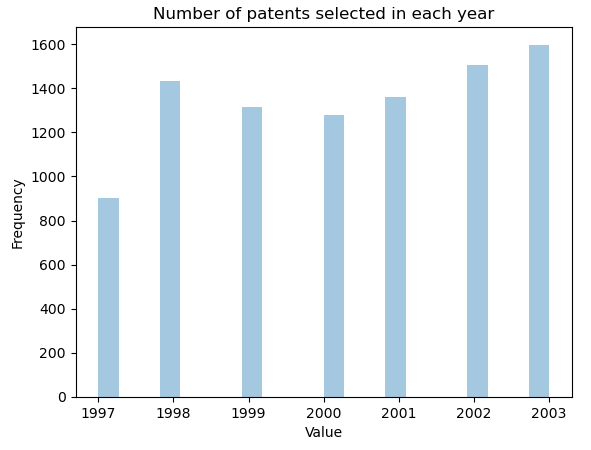

In [2]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/Patent_year.png', width=500, height=500)

- For tasks other than measuring technological innovation, I don't need time dimension for that,just one year of data would be good. Thus for these tasks, I'm using only the 1997 patent data.

- the length of detailed description text of 1997 patent data is shown below.The average text length in 1997 is 3886.97.

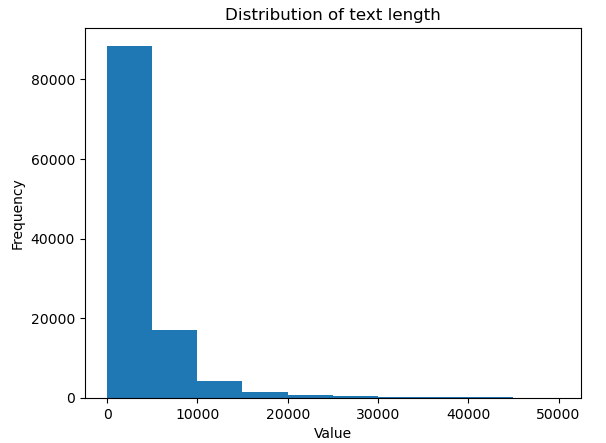

In [3]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/Text_len.png', width=500, height=500)

## 2.4 Format
- The raw data is in tsv format. The internal structure is simple: there're three columns: patent_id, detailed patent description (yes the entire text is contained in a single cell) and length of the detailed patent description. We can use readcsv to import the data easily.

# 3.Data Model

First, I need to convert the raw F0 patent data into a set of tables that conform to the Standard Text Analytic Data Model (F2). Actually I did this step twice, once for the patent description text from 1997-2003 to measure the technological innovation; Then only for the 1997 patent data.  The first task does not necessarily require all the F2 tables, so here I'm presenting these tables for 1997 patent description text only.

- Metadata for the source files include the patent id, the issue year and the Cooperative Patent Classification (CPC) classification of the patent. The LIB.csv file can be found here: 
https://virginia.box.com/s/1td9sjj2r0wj2lj83yrlzun10561a6zz

- The OHCO of our text is document level, we remove the non-letter characters, convert the terms to lower-case and add POS to each term. The token table can be found here: 
https://virginia.box.com/s/e1cpk5mu5gxoptxdjuvj4hrgniso62x6

- We also annotated the VOCAB with  statistical and linguistic features:                             
https://virginia.box.com/s/bcn9523mqk7ssy4r9l2lqnm8ybs7ucq0


# 4.Exploration

# Task 1: Measure the factor of importance for US patents granted in 2001 that belong to AI MachineLearning Category

## Idea: 
Just as in the 2021 AER (American Economic Review) paper "Measuring Technological Innovation over the Long Run"(Kelly et al.), I want to measure the importance of US granted patents based on their similarity between patents granted before and after them.

## Data Used for this task: 
- US patents granted between 1997-2003 that belong to AI MachineLearning category as defined by USPTO (see https://www.uspto.gov/ip-policy/economic-research/research-datasets/artificial-intelligence-patent-dataset)
- We do this mainly to reduce the sample size(from total 158776 patents in 2001 to 1361 patents in 2001 that belongs to ML category), otherwise not able to run the model on local computer

## Similarity of two patents
Generally as we learn in the class, we could calculate the TFIDF of the terms, then use vector space model to measure the distance between patents. 
But here I use a slightly different approach to measure the similarity between the patent pair(i,j) as follows.

- First, the modified version of TFIDF of word w in patent p that granted at time t:

$$TFBIDF_{w,i,t} = TF_{w,p} × BIDF_{w,t}$$ 

where 
$$BIDF_{w,p} = \log\left(\frac{\text{# of patents prior to }p}{1+\text{# of patents prior to p that include word w}}\right)$$

As for why BIDF(backward-IDF) is more sensible than IDF, it's because we are interested in the novelty or impact of patent p ’s text content given the history of innovation leading
up to the development of p. Due to computational constraint we define patents prior to p as the patents granted within last 2 years.

It's explained in the paper: "Consider, for example, Nikola Tesla’s famous 1888 patent (381,968) of an AC motor, which was among the first patents to use the phrase “alternating current,” a phrase used with great frequency throughout the twentieth century. Standard IDF would sharply deemphasize this term in the TFIDF vector representing Tesla’s patent because so many patents subsequently used this phrase so intensively. Therefore, TFIDF would give a misleading, and quite inverted, portrayal of the patent’s importance."
- Then we calculate the cosine similarity $\rho_{j,i} $ between the two normalized patent vectors

- Given the pairwise similarity, we next construct "Backward-Similarity" $BS_j^\tau = \sum_{i \in \beta_{j,\tau}} \rho_{j,i} $ where $\beta_{j,\tau}$ denotes the set of “prior” patents filed in the $\tau$ calendar years prior to j ’s filing. Due to data constraint, the window for prior patents is 2 years.

- Also "Forward-Similarity":$FS_j^\tau = \sum_{i \in \eta_{j,\tau}} \rho_{j,i} $ where $\eta{j,\tau}$ denotes the set of patents filed over the next $\tau$ calendar years following
patent j ’s filing. Due to data constraint, the window for later patents is also 2 years.

- Thus, we are able to measure the technological innovation only for US patents related to AI ML granted in 2001, since 1997 and 1998 data do not have BIDF; 1999 and 2000 data do not have properly defined BS, and 2002 2003 data do not have properly defined FS.

- Finally, our indicator of patent importance combines forward and backward similarity to identify patents that are both novel and impactful:
$$q_j^{\tau}=\frac{FS_j^\tau}{BS_j^\tau} $$

## Principal Component Analysis 

- Notice we need to use PCA after we derive the TFBIDF table, because the vocabulary size after removing non-letter characters, stopwords and words that appear too frequent(0.9*vocab size) or too infrequent (<100) is still very high; there are 14834 words remaining

- I look at the percentage of total variance explained to decide the number of principal components

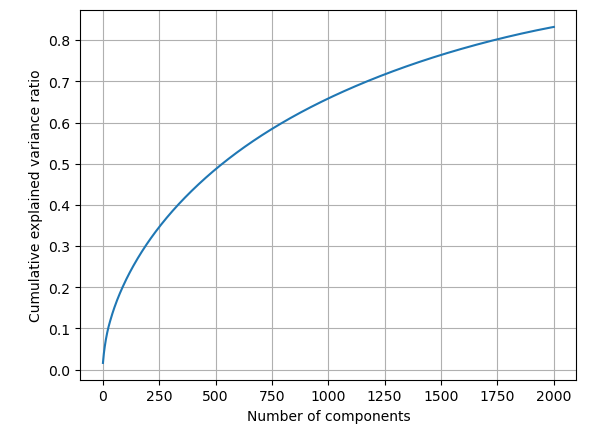

In [4]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/PCA_dim.png', width=500, height=500)

- So I select the number of components to be 2000 which explains >80% variance

## Results:
- Table of documents and components：https://virginia.box.com/s/dwblbfqm9jwby75ngbkiucac7ygkg1tr
- Table of components and word counts (i.e., the “loadings”) can be found here: https://virginia.box.com/s/pzrddfzdvril43vjkzku6l5e73qshmkq

## Pair-wise similarity 
- After we calculated the normalized TFBIDF table and reduced dimension using PCA, we are able to calculate pair-wise similarity between US patents in 2001

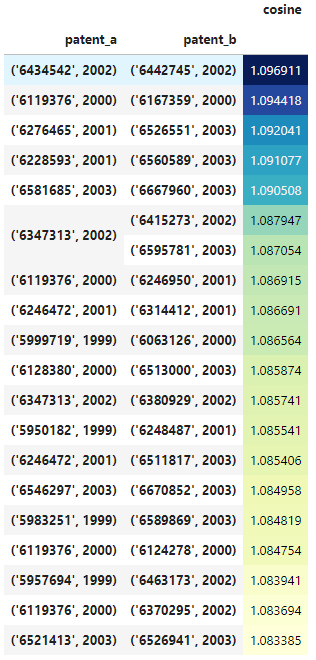

In [5]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/Cosine_dist.png', width=200, height=200)

## The distribution of Backward Similarity(BS): 

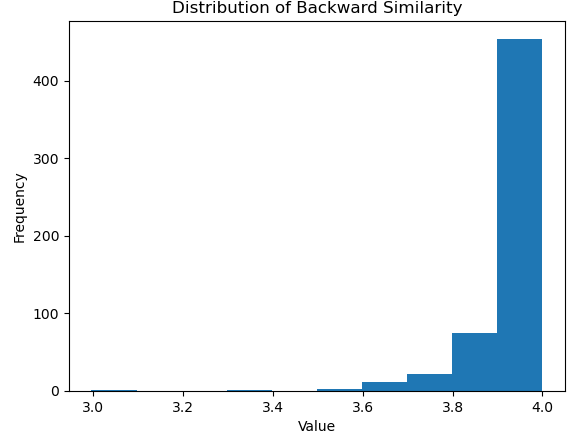

In [6]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/BS.png', width=400, height=400)

## The distribution of Forward Similarity(FS): 

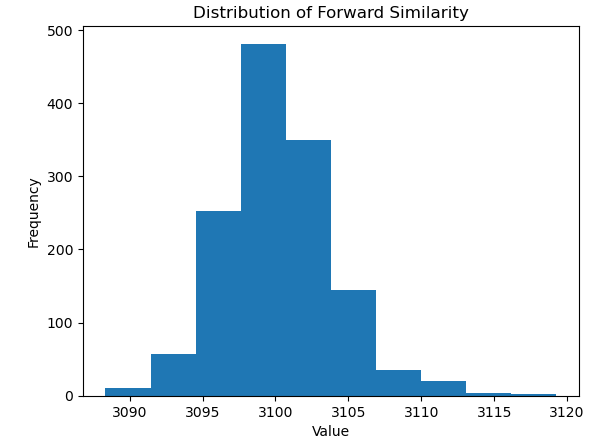

In [7]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/FS.png', width=400, height=400)

## The distribution of Factor of Importance(FOI): 

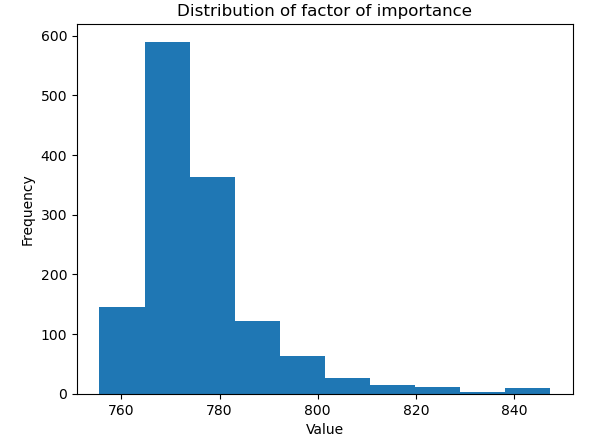

In [8]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/FOI.png', width=400, height=400)

- The factor of importance is a measure of technological innovation. From the distribution we find most of the patents are concentrated between 760-780. There's only a few patents that's highly valuable in terms of innovation, and there's not too much patetns with low innovation. This finding is intuitive since making innovation is hard, and low innovation patents might not be granted.


# Task 2: Topic Models (LDA)


## Idea: 
We want to classify the US patent in 1997 that belong to AI Machine Learning Category using topic modeling; then compare with the USPTO CPC classification to check whether topic modeling does a good job

- Hyper-parameters in the LDA model:
ngram_range = [1,2]; n_terms = 4000; n_topics = 9;max_iter = 20;n_top_terms = 9
- Number of Topics: set at 9, since there are 9 CPC (COOPERATIVE PATENT CLASSIFICATION) sections:see https://www.uspto.gov/web/patents/classification/cpc/html/cpc.html


## The resulting Theta & Phi Table can be found here: 
- THETA: https://virginia.box.com/s/scg1u475eydp20wsd6o796qqrovfkfbc

- PHI: https://virginia.box.com/s/bbcl1eamnzgsjyzirt32lelwcaubdlnb

## We next count how many topics there are in each cpc_section
- see graph below


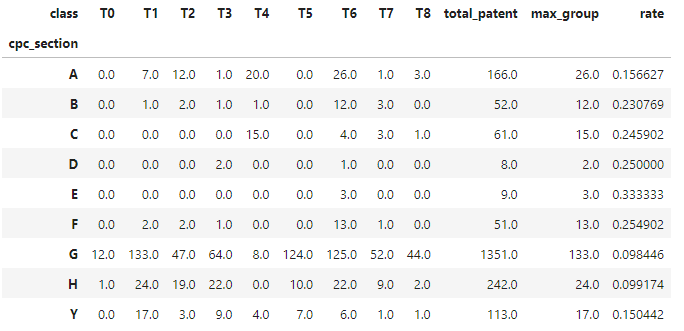

In [9]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/TOPIC.png', width=500, height=500)

- From the classification result, let's assume the topic that constitute the most of CPC section is the correct one(we can check this later), and calculate the proportion that each topic correctly classify the patent for each cpc section. Notice the proportion is the upperbound of correct prediction rate because of the assumption
- The correctly classified proportion ranges from 9.99% to 33.33%, and the average is 20.21%.
- If we don't use the topic model and just ramdomly assign the patent to one of the category, the probability of correct prediction is only 1/9, so it seems topic modeling is doing ok here.

### Look at the top 9 terms in each topic:
We want to check whether the classification makes sense

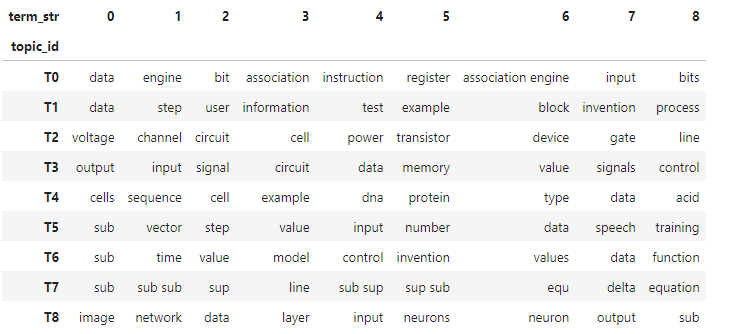

In [10]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/TOP_TERM.png', width=700, height=700)

- Let's check one cpc section, E. E is "FIXED CONSTRUCTIONS", and only contains Topic 06. By looking at the top terms it is not very obvious which section Topic 06 belongs into.

### Hierarchical cluster diagrams
We also created 2 Hierarchical cluster diagrams for the PHI and THETA table.
- For THETA:

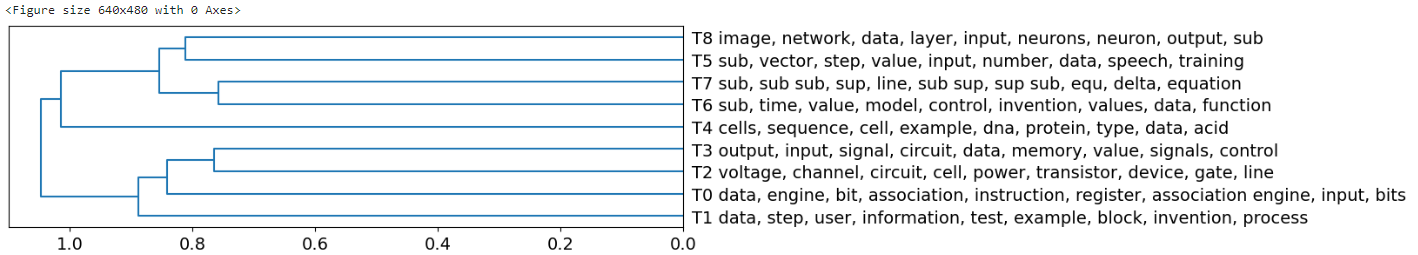

In [11]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/THETA_HAC.png', width=900, height=900)

- For PHI:

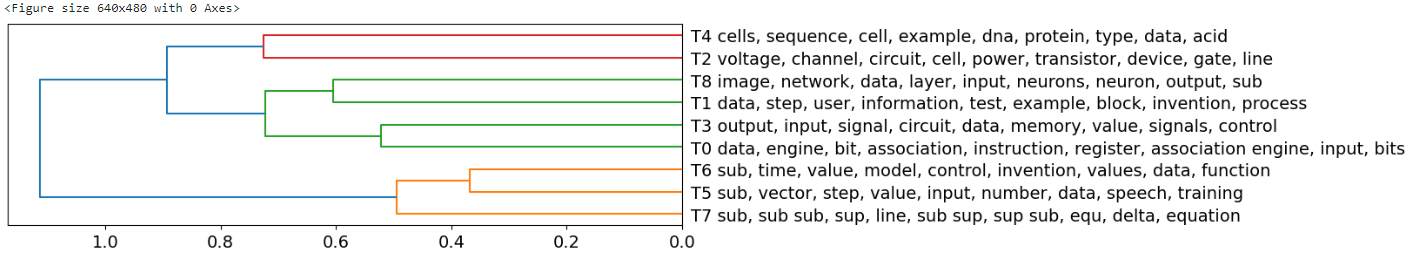

In [12]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/PHI_HAC.png', width=900, height=900)

- The clusters seem to make sense since similar topics are grouped closer together

# Task 3: Word Embeddings (word2vec)

### Idea: Same as before we use patents belong to AI ML category in 1997, then apply the Word2vec moodel to find the semantically similar words 

- word2vec parameters:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50,
    workers = 4
)


- Use document(patent) as the Bag

- Terms and embeddings table can be found here: https://virginia.box.com/s/7zqtov9rgrrez832vf8z2r1c6907hwk5

## t-SNE plots

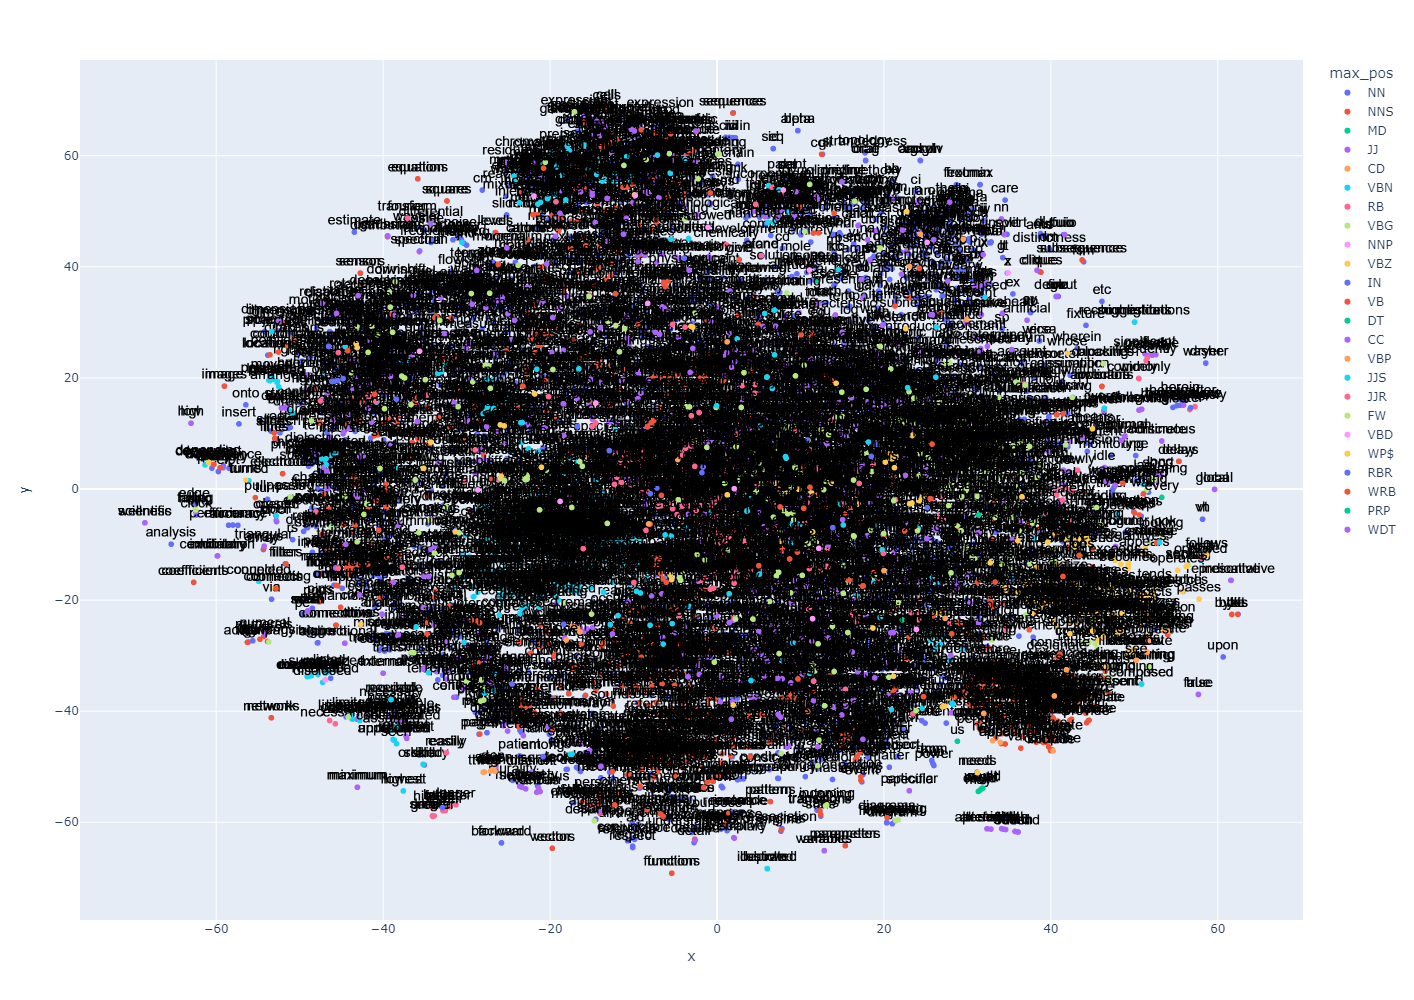

In [18]:
px.scatter(coords.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos', 
           hover_name='term_str',          
           #vector_size='tfbidf_max',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Task 4: Sentiment Analysis

## Idea: 
Use the same 1997 US patent data, we use 'salex_nrc' lexicon to assign emotion tag and sentiment polarity to each of the words, and weight them use the standard TFIDF 
- Hyper-parameters: idf_method='standard', tf_method = 'sum'


Results:

- Sentiment and emotion values as features in VOCAB: https://virginia.box.com/s/0bmfys62sa09rshlmbperjltnk9h3ul0

- Sentiment polarity and emotions for each document： https://virginia.box.com/s/37ls9cuepl0e2yexgv76glllyp36s6dt

## the distribution of patent-level sentiment (before trimming the low and high value) 

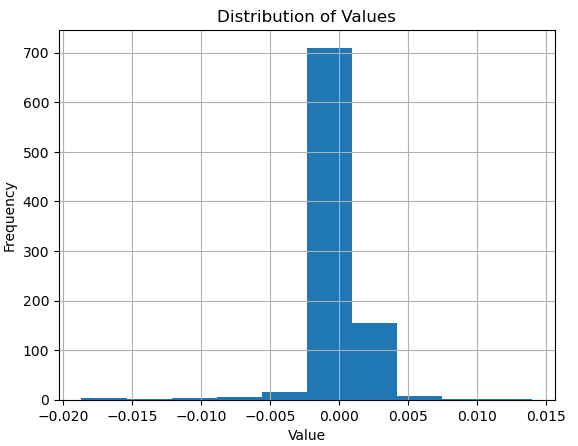

In [14]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/sent.png', width=400, height=400)

## the distribution of patent-level sentiment (after trimming ) 

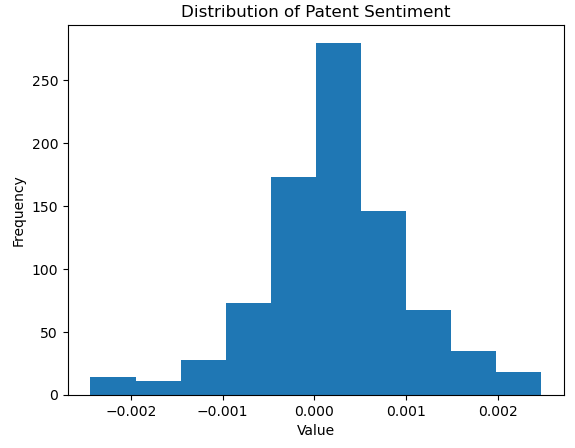

In [15]:
Image(filename = 'C:/Users/Lingmin/Desktop/Patent_project/Graphs/Sentiment.png', width=400, height=400)

- As seen in these plots, most of patent documents have close to zero sentiment polarity, which makes sense since patents are focused on describing the invention or process in a precise and accurate manner, so usually they are in a neutral language style

# 5.Interpretation

- In task 1(measuring technological innovation), we're trying to measure the technological innovation of US patents in 2001. We're able to perform the task, but whether that's a valid measure or not is not examined. To examine this, we need to compare our measure with others(for example, compare with market values of the patent derived by Kogan et al. (2017), or compare with citation patterns).


- In task 2(Topic modeling), we compare the model classification with the official CPC classification of patents and find the Topic models seems to work but not too accurate. 

- In task 3(Word Embedding), perhaps because the vocabulary is too large, the boundary of clusters in t-SNE is not very clear; still some of them are recognizable, for example the top cluster contains words like: gel, antibody, probe，peptides,protein... so it seems this cluster is related to biology.

- In task 4(Sentiment Analysis), the results are as expected, where the sentiment polarity are very close to zero since the legal documents are written in a neutral language style.